# Domain Adversarial training of Neural Networks

This notebook walks through the implementation of DANN algorithm to adapt domain from MNIST to MNIST_M.
First, clone the git repository containing utils :

In [12]:
!git clone https://github.com/vcoyette/DANN
%cd DANN

Cloning into 'DANN'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.
/content/DANN


 Download the MNIST_M dataset [here](https://drive.google.com/drive/folders/0B_tExHiYS-0vR2dNZEU4NGlSSW8), and place the archive in the data folder


In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os


In [0]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data_root, data_list, transform=None):
        self.root = data_root
        self.transform = transform
        with open(data_list, 'r') as f:
          self.data_list = f.readlines()

    def __len__(self):
      return len(self.data_list)

    def __getitem__(self, idx):
        img_name, labels = self.data_list[idx].split()
        imgs = Image.open(os.path.join(self.root, img_name)).convert('RGB')

        if self.transform:
          imgs = self.transform(imgs)
          
        labels = int(labels)

        return imgs, labels

In [0]:
# Load source images
transform_source = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,)),
     transforms.Lambda(lambda x: x.repeat(3, 1, 1))])

trainset_source = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform_source)
trainloader_source = torch.utils.data.DataLoader(trainset_source, batch_size=4,
                                          shuffle=True, num_workers=2)

testset_source = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform_source)
testloader_source = torch.utils.data.DataLoader(testset_source, batch_size=4,
                                         shuffle=False, num_workers=2)

In [0]:
# Load target images
img_transform_target = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

trainset_target = CustomDataset(
    data_root=os.path.join('data', 'mnist_m', 'mnist_m_train'),
    data_list=os.path.join('data', 'mnist_m', 'mnist_m_train_labels.txt'),
    transform=img_transform_target
)
trainloader_target = torch.utils.data.DataLoader(trainset_target, batch_size=4,
                                          shuffle=True, num_workers=2)
testset_target = CustomDataset(
    data_root=os.path.join('data', 'mnist_m', 'mnist_m_test'),
    data_list=os.path.join('data', 'mnist_m', 'mnist_m_test_labels.txt'),
    transform=img_transform_target
)
testloader_target = torch.utils.data.DataLoader(testset_target, batch_size=4,
                                          shuffle=True, num_workers=2)

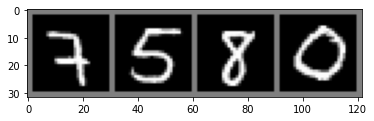

tensor(7) tensor(5) tensor(8) tensor(0)


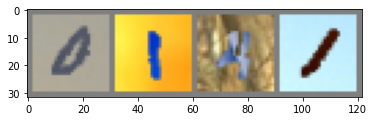

tensor(0) tensor(1) tensor(4) tensor(1)


In [0]:

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images from source
dataiter = iter(trainloader_source)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(4)))

# get some random training images from target
dataiter = iter(trainloader_target)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(4)))


# Baseline

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    # Conv
    self.conv1 = nn.Conv2d(3, 32, 5)
    self.conv2 = nn.Conv2d(32, 48, 5)

    # Fully-connected
    self.fc1 = nn.Linear(48 * 4 * 4, 100)
    self.fc2 = nn.Linear(100, 100)
    self.fc3 = nn.Linear(100, 10)

    # Pooling
    self.pool = nn.MaxPool2d(2, stride=2)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))

    x = x.view(-1, 48 * 4 * 4)

    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x

net = Net().to(device)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [0]:
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader_source, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.799
[1,  4000] loss: 0.148
[1,  6000] loss: 0.110
[1,  8000] loss: 0.090
[1, 10000] loss: 0.079
[1, 12000] loss: 0.075
[1, 14000] loss: 0.055
[2,  2000] loss: 0.053
[2,  4000] loss: 0.056
[2,  6000] loss: 0.040
[2,  8000] loss: 0.046
[2, 10000] loss: 0.040
[2, 12000] loss: 0.043
[2, 14000] loss: 0.042
Finished Training


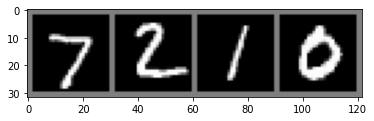

GroundTruth:  tensor(7) tensor(2) tensor(1) tensor(0)


In [0]:
dataiter = iter(testloader_source)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % labels[j] for j in range(4)))

In [0]:
outputs = net(images.to(device))

In [0]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % predicted[j]
                              for j in range(4)))

Predicted:  tensor(7, device='cuda:0') tensor(2, device='cuda:0') tensor(1, device='cuda:0') tensor(0, device='cuda:0')


In [0]:
def test(network, testloader):
  correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          images, labels = data[0].to(device), data[1].to(device)
          outputs = network(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct, total

correct, total = test(net, testloader_source)

print(f'Accuracy of the network on the {total} source test images:'
      f'{100 * correct / total} %')

correct, total = test(net, testloader_target)

print(f'Accuracy of the network on the {total} taget test images:'
      f'{100 * correct / total} %')

Accuracy of the network on the 10000 source test images:98.57 %


KeyboardInterrupt: ignored

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    # Conv
    self.conv1 = nn.Conv2d(3, 32, 5)
    self.conv2 = nn.Conv2d(32, 48, 5)

    # Fully-connected
    self.fc1 = nn.Linear(48 * 4 * 4, 100)
    self.fc2 = nn.Linear(100, 100)
    self.fc3 = nn.Linear(100, 10)

    # Pooling
    self.pool = nn.MaxPool2d(2, stride=2)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))

    x = x.view(-1, 48 * 4 * 4)

    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x

net = Net().to(device)

#DANN

In [0]:
class DomainRegressor(nn.Module):
  def __init__(self):
    super(DomainRegressor, self).__init__()

    self.fc1 = nn.Linear(48 * 4 * 4, 100)
    self.fc2 = nn.Linear(100, 1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = torch.sigmoid(self.fc2(x))

    return x

class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()

    # Fully-connected
    self.fc1 = nn.Linear(48 * 4 * 4, 100)
    self.fc2 = nn.Linear(100, 100)
    self.fc3 = nn.Linear(100, 10)

    # Pooling
    self.pool = nn.MaxPool2d(2, stride=2)
    self.logsoftmax = nn.LogSoftmax(dim=1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.logsoftmax(self.fc3(x))

    return x

class FeatureExtractor(nn.Module):
  def __init__(self):
    super(FeatureExtractor, self).__init__()


    # Conv
    self.conv1 = nn.Conv2d(3, 32, 5)
    self.conv2 = nn.Conv2d(32, 48, 5)

      # Pooling
    self.pool = nn.MaxPool2d(2, stride=2)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))

    x = x.view(-1, 48 * 4 * 4)

    return x


In [0]:
class DANN(nn.Module):
  def __init__(self, feature_extractor, domain_regressor, classifier):
    super(DANN, self).__init__()

    self.feature_extractor = feature_extractor
    self.domain_regressor = domain_regressor
    self.classifier = classifier

    self.domain_regressor.register_backward_hook(self.gradient_reversal)

  def gradient_reversal(self, module, grad_in, grad_out):
    return (-grad_in[0],)

  def forward(self, x):
    x = self.feature_extractor(x)
    
    return self.classifier(x), self.domain_regressor(x)

In [0]:
net = DANN(FeatureExtractor(), DomainRegressor(), Classifier()).to(device)

In [0]:
dataiter = iter(testloader_source)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % labels[j] for j in range(4)))

In [0]:
outputs = net(images.to(device))

In [0]:
_, predicted = torch.max(outputs[0], 1)

print('Predicted: ', ' '.join('%5s' % predicted[j]
                              for j in range(4)))

In [0]:
criterion_classifier = nn.NLLLoss()
optimizer_classifier = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

criterion_domain_regressor = nn.BCELoss()
optimizer_domain_regressor = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

l = 0.8



In [0]:
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, (data_source, data_target) in enumerate(zip(trainloader_source, trainloader_target), 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data_source[0].to(device), data_source[1].to(device)

        # forward + backward + optimize
        y_pred, domain_pred = net(inputs)
        loss = criterion_classifier(y_pred, labels) - \
               l * criterion_domain_regressor(domain_pred, torch.zeros_like(domain_pred).to(device))

        optimizer_classifier.zero_grad()
        optimizer_domain_regressor.zero_grad()

        loss.backward()

        optimizer_classifier.step()
        optimizer_domain_regressor.step()


        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data_target[0].to(device), data_target[1].to(device)

        _, domain_pred = net(inputs)
        loss = - l * criterion_domain_regressor(domain_pred, torch.ones_like(domain_pred).to(device))

        optimizer_classifier.zero_grad()
        optimizer_domain_regressor.zero_grad()

        loss.backward()

        optimizer_domain_regressor.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

In [0]:
print(len(trainloader_source))

In [0]:
print(len(trainloader_target))